In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from networkx.algorithms.components import node_connected_component as ncc


from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal

SplitTestData = "2018-12"
SplitValData = "2018-09"

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,date):
    X_te = X[date:]
    y_te = y[date:]
    X_tr = X[:date]
    y_tr = y[:date]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction #0.1*pred_test +0.2*pred_test_cat + 0.7*pred_test_xgb
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    #plt.ylim([200,330])
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    


# SELEZIONA COME NORMALIZZARE:

In [3]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature):
    size = len(feature)
    return min_max_scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    #return quantile_transformer.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    
def unscale(scaled, original):
    size2 = len(scaled)
    size1 = len(original)
    return min_max_scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]
    #return quantile_transformer.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [10]:
# Read train and test files
train_df = pd.read_csv('processed_train.csv')

train_df.date = train_df.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
train_df = train_df.set_index("date")


In [11]:
targets = pd.DataFrame()
for sku in train_df.sku.unique():
    targets[sku] = train_df.loc[train_df['sku'] == sku]["scaled_target"]
targets.head()

,2704,2718,1603,1732,2249,1356,1371,2396,1633,2401,...,144,1051,546,1058,549,1065,554,686,688,1206
date,,,,,,,,,,,,,,,,,,,,,
2016-12-17,0.528132,0.373639,0.425342,0.187454,0.588985,0.477764,0.347097,0.079952,0.374038,0.642186,...,0.486490,0.637477,0.109741,0.139787,0.102699,0.194845,0.121289,0.418289,0.138139,0.172590
2016-12-24,0.729906,0.385207,0.425634,0.201649,0.540474,0.289994,0.270542,0.054262,0.335511,0.565512,...,0.407090,0.458953,0.090556,0.118372,0.106018,0.163517,0.098738,0.322606,0.120572,0.132554
2016-12-31,0.194152,0.126157,0.165571,0.000000,0.295729,0.041487,0.064536,0.000000,0.000000,0.332343,...,0.053880,0.064080,0.000000,0.055989,0.047927,0.056471,0.000000,0.050793,0.030799,0.029706
2017-01-07,0.664149,0.500851,0.764335,0.130467,0.253876,0.582561,0.761234,0.251337,0.345402,0.260606,...,0.112516,0.156079,0.135753,0.178347,0.132053,0.231984,0.138481,0.111800,0.161601,0.211821
2017-01-14,0.685698,0.547292,0.892546,0.091953,0.144488,0.612621,0.806488,0.352417,0.445781,0.195421,...,0.110378,0.148380,0.178706,0.219959,0.158161,0.290207,0.184171,0.113596,0.211160,0.270787


In [38]:
def takeCorr(elem):
    return elem[1]

correlations = []
for c1 in targets.columns:
    for c2 in targets.columns:
        if c1 < c2:
            if pearsonr(targets[c1],targets[c2])[0] > 0.6:
#             if targets[c1].corr(targets[c2]) > 0.90:
                correlations.append([(c1,c2),targets[c1].corr(targets[c2])])
correlations.sort(reverse=True,key=takeCorr)
print(correlations)

[[(688, 1058), 0.9904646612859503], [(546, 549), 0.9901041780990425], [(688, 1206), 0.9881280571921007], [(549, 1058), 0.9862329935273375], [(144, 686), 0.9857050268940731], [(546, 554), 0.985358578568291], [(549, 1027), 0.9850381753114951], [(549, 554), 0.9850060919415845], [(1058, 1065), 0.983051757993448], [(549, 688), 0.9823788484954358], [(549, 1065), 0.9821019589426977], [(546, 1027), 0.9817983810057049], [(1058, 1206), 0.9791495775728974], [(549, 1035), 0.9788270895218814], [(1035, 1206), 0.9784673873589802], [(546, 1058), 0.976815519651298], [(554, 1065), 0.976362719232447], [(688, 1027), 0.9762887841062925], [(1027, 1058), 0.9760549880350066], [(688, 1065), 0.9749041221075027], [(546, 1065), 0.9744080584900161], [(549, 1206), 0.97380960514296], [(2249, 2401), 0.9732861781552432], [(688, 1035), 0.9702080599570676], [(1027, 1035), 0.9687469259944607], [(1027, 1065), 0.9677755918945224], [(1027, 1206), 0.9676200197966752], [(554, 1027), 0.9675287610744209], [(546, 688), 0.9671735

In [39]:
G = nx.Graph()
for e in range(0,len(correlations)):
    G.add_edge(correlations[e][0][0],correlations[e][0][1])
print(len(G))

20


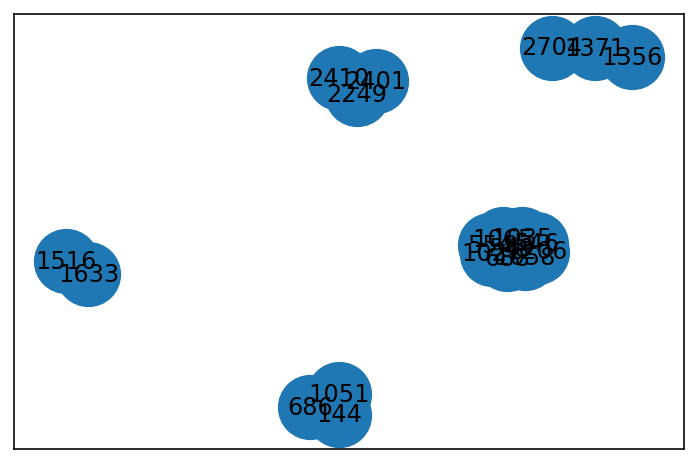

In [40]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 1000)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='r')
nx.draw_networkx_labels(G, pos)
plt.show()

In [41]:
groups = []


for couple, corr in correlations:
    found = False
    for g in groups:
        
        if couple in g:
            if not couple[1] in g:
                g.append(couple[1])
            found = True
        elif couple[1] in g:
            if not couple[0] in g:
                g.append(couple[0])
            found = True
        
    if not found :
        groups.append([couple[0],couple[1]])
print(len(groups))
for i in range(0,len(groups)):
    for g in groups[i+1:]:
        for e in groups[i]:
            if e in g:
                groups[i].extend(g)
                groups[i] = list(dict.fromkeys(groups[i]))
                groups.remove(g)
                break
        
(groups)
    

14


[[688, 1058, 549, 546, 1027, 554, 1035, 1206, 1065],
 [144, 686, 1051],
 [2249, 2401, 2410],
 [1356, 1371, 2704],
 [1516, 1633]]

[[688, 1058, 549, 546, 1027, 554], [1035, 1206], [144, 686], [2249, 2401]] 

In [42]:
train_df['sku'].unique()

array([2704, 2718, 1603, 1732, 2249, 1356, 1371, 2396, 1633, 2401, 2410,
       1516, 1027, 1035,  144, 1051,  546, 1058,  549, 1065,  554,  686,
        688, 1206])

In [43]:
# sku_groups = {
# "A" :[1603, 2705, 1608, 1618, 1371], #MAPE 3.8
# "B" :[2249, 2401, 2365, 2410], #MAPE 5.8
# "C" :[1554, 1600], #MAPE 5.9
# "D" :[1365, 1732, 1472, 2682], #MAPE 5.5
# "E" :[688,1058,549,546,1027,1035,554,1206,1065,1365,1732,1472,1600,1554,1516,1633,1371
#       ,1356,2678,2683,2681,1603,2705,1618,2365,2696,2718,2711,2712,2698,2396,2682,2707,2704,2360],#MAPE 8.8
# "F" :[144, 686, 1051] #MAPE 10
# }
sku_groups ={
    "A" : [688, 1058, 549, 546, 1027, 554, 1035, 1206, 1065],
    "B" : [144, 686, 1051],
    "C" : [2249, 2401, 2410],
    "D" : [1356, 1371, 2704],
    "E" : [1516, 1633]
}

In [44]:
i = 0
for sku in train_df['sku'].unique():
    j = i
    for l,g in sku_groups.items():
    
        if sku in g:
            print(str(sku) + " : "+l)
            i = i+1
            break
    if j == i:
        print("NOT FOUND "+str(sku))
    
print(i)
            

2704 : D
NOT FOUND 2718
NOT FOUND 1603
NOT FOUND 1732
2249 : C
1356 : D
1371 : D
NOT FOUND 2396
1633 : E
2401 : C
2410 : C
1516 : E
1027 : A
1035 : A
144 : B
1051 : B
546 : A
1058 : A
549 : A
1065 : A
554 : A
686 : B
688 : A
1206 : A
20
